## Utility

In [1]:
import sys
import csv
import re
import pandas as pd
import numpy as np
import torch.nn.functional as fn
import torch as th


def load_module(entity_file, relation_file, entity_emb_file, rel_emb_file):
  # Get drugname/disease name to entity ID mappings
  entity_map = {}
  entity_id_map = {}
  relation_map = {}
  nodetype_ids={}
  ntypePattern = re.compile(r"^(.*)::")

  with open(entity_file, newline='', encoding='utf-8') as csvfile:
      reader = csv.DictReader(csvfile, delimiter='\t', fieldnames=['id','name'])
      for row_val in reader:
          ntype = ntypePattern.match(row_val['name']).group(1)
          iid = int(row_val['id'])
          entity_map[row_val['name']] = iid
          entity_id_map[iid] = row_val['name']
          if ntype not in nodetype_ids:
              nodetype_ids[ntype]=[]
          nodetype_ids[ntype].append(iid)
          
  with open(relation_file, newline='', encoding='utf-8') as csvfile:
      reader = csv.DictReader(csvfile, delimiter='\t', fieldnames=['id','name'])
      for row_val in reader:
          relation_map[row_val['name']] = int(row_val['id'])

  # Load embeddings
  entity_emb = np.load(entity_emb_file)
  rel_emb = np.load(rel_emb_file)

  return {
      "entity_map": entity_map,
      "entity_id_map": entity_id_map,
      "relation_map": relation_map,
      "nodetype_ids": nodetype_ids,
      "entity_embedding": entity_emb,
      "rel_embedding": rel_emb
  }

In [2]:
def distance(head, tail):
  score = head - tail
  return th.norm(score, p=2, dim=-1)


def transE_l2(head, rel, tail, gamma=12.0):
  score = head + rel - tail
  return gamma - th.norm(score, p=2, dim=-1)


def query(model_map, relations: list[str], source_id: str, reverse_prediction: bool = True):
  """
  relations: ['Hetionet::CtD::Compound:Disease', 'GNBR::T::Compound:Disease', 'DRUGBANK::treats::Compound:Disease']
  source_id: MESH:D015673
  """
  if reverse_prediction:
    target, source = relations[0].split('::')[2].split(':')
  else:
    source, target = relations[0].split('::')[2].split(':')

  relation_map = model_map.get("relation_map")
  relation_ids = [relation_map[relation] for relation in relations]
  relation_ids = th.tensor(relation_ids)
  rel_emb = model_map.get("rel_embedding")
  relations_embs = [th.tensor(rel_emb[rid]) for rid in relation_ids]

  sources = [source + "::" + source_id]

  entity_map = model_map.get("entity_map")
  source_ids = [entity_map[source]
          for source in sources if source in entity_map]
  source_ids = th.tensor(source_ids)

  nodetype_ids = model_map.get("nodetype_ids")
  target_ids = nodetype_ids[target]
  target_ids = th.tensor(target_ids)

  entity_emb = model_map.get("entity_embedding")
  target_emb = th.tensor(entity_emb[target_ids])

  return {
    "relation_ids": relation_ids,
    "relations_embeddings": relations_embs,
    "source_ids": source_ids,
    "target_ids": target_ids,
    "target_embedding": target_emb,
    "relations": relations
  }


In [3]:
# one for each
def relation_each(model_map, results, reverse_prediction=True, topk=100):
  allpd = pd.DataFrame()
  relations_embs = results.get("relations_embeddings")
  source_ids = results.get("source_ids")
  entity_emb = model_map.get("entity_embedding")
  target_emb = results.get("target_embedding")
  relations = results.get("relations")
  target_ids = results.get("target_ids")
  entity_id_map = model_map.get("entity_id_map")

  for rid in range(len(relations_embs)):
    relation_embs = relations_embs[rid]
    for source_id in source_ids:
      source_emb = th.tensor(entity_emb[source_id])
      if reverse_prediction:
        score = fn.logsigmoid(transE_l2(target_emb, relation_embs, source_emb))
      else:
        score = fn.logsigmoid(transE_l2(source_emb, relation_embs, target_emb))

      newpd= pd.DataFrame({
          "relation": relations[rid],
          "source_id": int(source_id),
          "target_id": target_ids.tolist(),
          "score": score.tolist()
      })

      allpd=pd.concat([allpd,newpd])
      # scores_per_sources.append(score)
      # dids.append(target_ids)

  topkpd = allpd.sort_values("score", ascending=False).head(n=topk)
  topkpd["source"] = [entity_id_map[i] for i in topkpd["source_id"]]
  topkpd["target"] = [entity_id_map[i] for i in topkpd["target_id"]]
  return topkpd


In [4]:
# average source_id
def relation_ave(model_map, results, reverse_prediction=True, topk=100):
    relations_embs = results.get("relations_embeddings")
    entity_emb = model_map.get("entity_embedding")
    source_ids = results.get("source_ids")
    target_ids = results.get("target_ids")
    target_emb = results.get("target_embedding")
    entity_id_map = model_map.get("entity_id_map")
    relations = results.get("relations")
    allpd = pd.DataFrame()
    for rid in range(len(relations_embs)):
        relation_embs = relations_embs[rid]

        source_emb = th.mean(th.tensor(entity_emb[source_ids]),0)
        if reverse_prediction:
            score = fn.logsigmoid(transE_l2(target_emb, relation_embs, source_emb))
        else:
            score = fn.logsigmoid(transE_l2(source_emb, relation_embs, target_emb))
        newpd= pd.DataFrame({
            "relation": relations[rid],
            "target_id": target_ids.tolist(),
            "score": score.tolist()
        })

        allpd=pd.concat([allpd,newpd])
        # scores_per_sources.append(score)
        # dids.append(target_ids)

    topkpd=allpd.sort_values("score",ascending=False).head(n=topk)
    topkpd["target"] = [entity_id_map[i] for i in topkpd["target_id"]] 
    return topkpd

In [5]:
def check_relation_exists(row, relations_df):
    source_type, source_id = row['source'].split("::")
    target_type, target_id = row['target'].split("::")
    option1 = (source_id, source_type, target_id, target_type) in relations_df.index

    target_type, target_id = row['source'].split("::")
    source_type, source_id = row['target'].split("::")
    option2 = (source_id, source_type, target_id, target_type) in relations_df.index
    return option1 or option2

## DRKG

In [13]:
import os

# dataset = 'drkg-hsdn-custom-malacards-filtered-all'
dataset = 'drkg'
working_dir = f'./{dataset}'
idx = 2
model_dir = os.path.join(working_dir, f'models/TransE_l2_{dataset}_{idx}')
entity_idmap_file = os.path.join(working_dir, 'data/train/entities.tsv')
relation_idmap_file = os.path.join(working_dir, 'data/train/relations.tsv')
entity_emb_file = os.path.join(model_dir, f'{dataset}_TransE_l2_entity.npy')
rel_emb_file = os.path.join(model_dir, f'{dataset}_TransE_l2_relation.npy')
entity_relation_map = load_module(entity_idmap_file, relation_idmap_file, entity_emb_file, rel_emb_file)

In [14]:
entity_relation_map.get("relation_map").keys()

dict_keys(['STRING::REACTION::Gene:Gene', 'Hetionet::AeG::Anatomy:Gene', 'Hetionet::GcG::Gene:Gene', 'Hetionet::CrC::Compound:Compound', 'GNBR::in_tax::Gene:Tax', 'STRING::CATALYSIS::Gene:Gene', 'Hetionet::AuG::Anatomy:Gene', 'DRUGBANK::ddi-interactor-in::Compound:Compound', 'Hetionet::GiG::Gene:Gene', 'Hetionet::CdG::Compound:Gene', 'bioarx::HumGenHumGen::Gene:Gene', 'Hetionet::Gr>G::Gene:Gene', 'Hetionet::GpBP::Gene:Biological Process', 'INTACT::ASSOCIATION::Gene:Gene', 'STRING::OTHER::Gene:Gene', 'GNBR::K::Compound:Gene', 'STRING::BINDING::Gene:Gene', 'STRING::PTMOD::Gene:Gene', 'Hetionet::GpCC::Gene:Cellular Component', 'Hetionet::GpPW::Gene:Pathway', 'Hetionet::PCiC::Pharmacologic Class:Compound', 'Hetionet::CcSE::Compound:Side Effect', 'Hetionet::GpMF::Gene:Molecular Function', 'Hetionet::AdG::Anatomy:Gene', 'GNBR::Q::Gene:Gene', 'GNBR::T::Compound:Disease', 'INTACT::PHYSICAL ASSOCIATION::Gene:Gene', 'DRUGBANK::target::Compound:Gene', 'GNBR::V+::Gene:Gene', 'GNBR::E::Compound:Gen

In [15]:
entities = entity_relation_map.get('entity_map').keys()
print(list(entities)[0])
drugs = [entity for entity in entities if entity.startswith('Compound::DrugBank:DB')]
len(drugs)

Gene::1813


0

In [16]:
relations = ['Hetionet::CtD::Compound:Disease', 'GNBR::T::Compound:Disease', 'DRUGBANK::treats::Compound:Disease']
# source_id = "MONDO:0005404"
source_id = "MESH:D015673"

results = query(entity_relation_map, relations, source_id)
topkpd = relation_each(entity_relation_map, results, topk=10556)
topkpd_ave = relation_ave(entity_relation_map, results, topk=10556)
topkpd, topkpd_ave

(                                 relation  source_id  target_id     score  \
 7588            GNBR::T::Compound:Disease      32452      44218 -0.101534   
 3589            GNBR::T::Compound:Disease      32452      17539 -0.159259   
 2705            GNBR::T::Compound:Disease      32452      11413 -0.160583   
 6245            GNBR::T::Compound:Disease      32452      37055 -0.160688   
 5561            GNBR::T::Compound:Disease      32452      32682 -0.166167   
 ...                                   ...        ...        ...       ...   
 1715   DRUGBANK::treats::Compound:Disease      32452       6585 -2.533825   
 11139           GNBR::T::Compound:Disease      32452      58552 -2.533866   
 10548           GNBR::T::Compound:Disease      32452      56399 -2.534014   
 9921            GNBR::T::Compound:Disease      32452      53939 -2.534143   
 13867           GNBR::T::Compound:Disease      32452      68275 -2.534419   
 
                       source                  target  
 7588 

/opt/conda/envs/biomedgps/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/envs/biomedgps/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/envs/biomedgps/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/envs/biomedgps/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

<Axes: xlabel='score', ylabel='Count'>

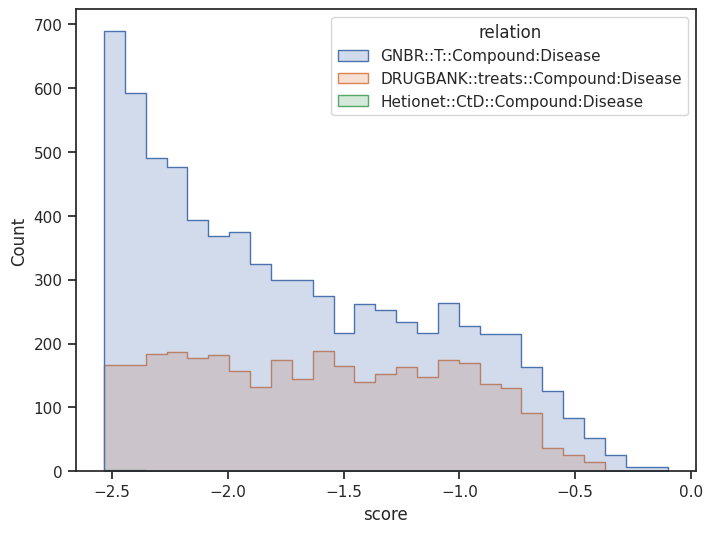

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='ticks')
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(x='score', hue='relation', data=topkpd, element='step', ax=ax)

In [18]:
import pandas as pd

rootdir = os.path.dirname(os.getcwd())
entity_file = os.path.join(rootdir, 'graph_data/entities.tsv')
entities = pd.read_csv(entity_file, sep='\t', dtype=str)

entities.head()

,id,name,label,resource,description,synonyms,pmids,taxid,xrefs
0,SYMP:0000149,obsolete sudden onset of severe chills,Symptom,SymptomOntology,NaN,NaN,NaN,NaN,NaN
1,SYMP:0000259,dry hacking cough,Symptom,SymptomOntology,A dry cough that is characterized by a rough a...,NaN,NaN,NaN,NaN
2,SYMP:0000729,pulmonary consolidation,Symptom,SymptomOntology,A respiratory system and chest symptom that is...,NaN,NaN,NaN,NaN
3,SYMP:0000746,enanthem,Symptom,SymptomOntology,A skin and integumentary tissue symptom that i...,NaN,NaN,NaN,NaN
4,SYMP:0000412,anxiety,Symptom,SymptomOntology,A neurological and physiological symptom that ...,NaN,NaN,NaN,NaN


In [21]:
# Load relations_df and set up an index
relations_df = pd.read_csv(os.path.join(working_dir, "data/relations.tsv"), sep="\t", dtype=str)
relations_df.set_index(['source_id', 'source_type', 'target_id', 'target_type'], inplace=True)

In [22]:
# Join the topkpd with the entity dataframe
df = entities.copy()
df["node_id"] = entities["label"] + "::" + entities["id"]
merged = topkpd.merge(df, left_on='target', right_on='node_id')

# Apply the function with axis=1 to check if the relationship exists
merged["status"] = merged.apply(check_relation_exists, args=(relations_df,), axis=1)
merged.to_csv(os.path.join(model_dir, f"mecfs-output.tsv"), sep="\t", index=False)
merged.head()

/tmp/ipykernel_2184353/4040759509.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  option1 = (source_id, source_type, target_id, target_type) in relations_df.index
/tmp/ipykernel_2184353/4040759509.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  option2 = (source_id, source_type, target_id, target_type) in relations_df.index


,relation,source_id,target_id,score,source,target,id,name,label,resource,description,synonyms,pmids,taxid,xrefs,node_id,status
0,GNBR::T::Compound:Disease,32452,11413,-0.160583,Disease::MESH:D015673,Compound::MESH:D002331,MESH:D002331,Carnitine,Compound,DrugBank,A constituent of STRIATED MUSCLE and LIVER. It...,Levocarnitine|L Carnitine|L-Carnitine|1-Propan...,NaN,NaN,MESH:D002331|UMLS:C0007258|UMLS:C0087163|UMLS:...,Compound::MESH:D002331,True
1,DRUGBANK::treats::Compound:Disease,32452,11413,-1.066987,Disease::MESH:D015673,Compound::MESH:D002331,MESH:D002331,Carnitine,Compound,DrugBank,A constituent of STRIATED MUSCLE and LIVER. It...,Levocarnitine|L Carnitine|L-Carnitine|1-Propan...,NaN,NaN,MESH:D002331|UMLS:C0007258|UMLS:C0087163|UMLS:...,Compound::MESH:D002331,True
2,GNBR::T::Compound:Disease,32452,32682,-0.166167,Disease::MESH:D015673,Compound::MESH:C116917,MESH:C116917,acylcarnitine,Compound,DrugBank,NaN,NaN,NaN,NaN,UMLS:C0368608|MESH:C116917,Compound::MESH:C116917,True
3,DRUGBANK::treats::Compound:Disease,32452,32682,-0.917624,Disease::MESH:D015673,Compound::MESH:C116917,MESH:C116917,acylcarnitine,Compound,DrugBank,NaN,NaN,NaN,NaN,UMLS:C0368608|MESH:C116917,Compound::MESH:C116917,True
4,GNBR::T::Compound:Disease,32452,7886,-0.328975,Disease::MESH:D015673,Compound::MESH:D002395,MESH:D002395,Catecholamines,Compound,DrugBank,A general class of ortho-dihydroxyphenylalkyla...,Sympathin|Sympathins|Catecholamine,NaN,NaN,CHEBI:33567|UMLS:C0007412|MESH:D002395,Compound::MESH:D002395,False


In [23]:
topkpd_ave.head()

,relation,target_id,score,target
653,DRUGBANK::treats::Compound:Disease,2361,-0.207761,Compound::DB00515
361,DRUGBANK::treats::Compound:Disease,1295,-0.213103,Compound::DB00333
135,DRUGBANK::treats::Compound:Disease,458,-0.214547,Compound::DB00328
1519,DRUGBANK::treats::Compound:Disease,5740,-0.217193,Compound::DB00564
543,DRUGBANK::treats::Compound:Disease,1992,-0.223037,Compound::DB00091


In [24]:
# Join the topkpd with the entity dataframe
df = entities.copy()
df["node_id"] = entities["label"] + "::" + entities["id"]
merged = topkpd_ave.merge(df, left_on='target', right_on='node_id')
merged.to_csv(os.path.join(model_dir, f"mecfs-ave-output.tsv"), sep="\t", index=False)
merged.head()

,relation,target_id,score,target,id,name,label,resource,description,synonyms,pmids,taxid,xrefs,node_id
0,GNBR::T::Compound:Disease,11374,-0.308836,Compound::MESH:D004967,MESH:D004967,Estrogens,Compound,MESH,Compounds that interact with ESTROGEN RECEPTOR...,"Agents, Estrogenic|Effects, Estrogenic|Agonist...",NaN,NaN,NaN,Compound::MESH:D004967
1,DRUGBANK::treats::Compound:Disease,11374,-1.047709,Compound::MESH:D004967,MESH:D004967,Estrogens,Compound,MESH,Compounds that interact with ESTROGEN RECEPTOR...,"Agents, Estrogenic|Effects, Estrogenic|Agonist...",NaN,NaN,NaN,Compound::MESH:D004967
2,GNBR::T::Compound:Disease,11000,-0.332418,Compound::MESH:D013256,MESH:D013256,Steroids,Compound,DrugBank,Any saponin derived from a hydroxysteroid.,"Steroids, Catatoxic|NSAID|a steroid|Steroid|Ca...",NaN,NaN,CHEBI:35341|CHEBI:61655|UMLS:C0007401|MESH:D01...,Compound::MESH:D013256
3,DRUGBANK::treats::Compound:Disease,11000,-1.307773,Compound::MESH:D013256,MESH:D013256,Steroids,Compound,DrugBank,Any saponin derived from a hydroxysteroid.,"Steroids, Catatoxic|NSAID|a steroid|Steroid|Ca...",NaN,NaN,CHEBI:35341|CHEBI:61655|UMLS:C0007401|MESH:D01...,Compound::MESH:D013256
4,GNBR::T::Compound:Disease,24971,-0.398128,Compound::MESH:D008751,MESH:D008751,Methylene Blue,Compound,DrugBank,A compound consisting of dark green crystals o...,C.i. basic blue 9 trihydrate|CI-52015|Methylth...,NaN,NaN,UMLS:C0025746|UMLS:C0813444|CHEMBL:CHEMBL55049...,Compound::MESH:D008751


In [26]:
disease_relations = ['Hetionet::DrD::Disease:Disease', 'PrimeKG::parent-child:Disease:Disease']
# source_id = "MONDO:0005404"
source_id = "MESH:D015673"

disease_results = query(entity_relation_map, disease_relations, source_id)
disease_topkpd = relation_each(entity_relation_map, disease_results, topk=10556)
disease_topkpd_ave = relation_ave(entity_relation_map, disease_results, topk=10556)
disease_topkpd, disease_topkpd_ave

(                            relation  source_id  target_id     score  \
 1194  Hetionet::DrD::Disease:Disease      32452      32452 -0.182381   
 932   Hetionet::DrD::Disease:Disease      32452      28092 -1.370402   
 350   Hetionet::DrD::Disease:Disease      32452      14172 -1.392184   
 223   Hetionet::DrD::Disease:Disease      32452       9628 -1.668559   
 294   Hetionet::DrD::Disease:Disease      32452      11795 -1.752007   
 ...                              ...        ...        ...       ...   
 1304  Hetionet::DrD::Disease:Disease      32452      34346 -9.451233   
 1438  Hetionet::DrD::Disease:Disease      32452      36303 -9.457798   
 2508  Hetionet::DrD::Disease:Disease      32452      52731 -9.492171   
 3309  Hetionet::DrD::Disease:Disease      32452      65616 -9.494130   
 3014  Hetionet::DrD::Disease:Disease      32452      60783 -9.498412   
 
                      source                 target  
 1194  Disease::MESH:D015673  Disease::MESH:D015673  
 932   Disease

In [27]:
# Join the topkpd with the entity dataframe
disease_df = entities.copy()
disease_df["node_id"] = entities["label"] + "::" + entities["id"]
disease_merged = disease_topkpd.merge(disease_df, left_on='target', right_on='node_id')
disease_merged.head()

,relation,source_id,target_id,score,source,target,id,name,label,resource,description,synonyms,pmids,taxid,xrefs,node_id
0,Hetionet::DrD::Disease:Disease,32452,6291,-1.943565,Disease::MESH:D015673,Disease::MESH:D012559,MESH:D012559,Schizophrenia,Disease,MESH,A severe emotional disorder of psychotic depth...,Schizophrenic Disorder|Dementia Praecox|Schizo...,NaN,NaN,MESH:D012559|HP:0100753|DOID:5419,Disease::MESH:D012559
1,Hetionet::DrD::Disease:Disease,32452,4978,-2.115182,Disease::MESH:D015673,Disease::MESH:D009765,MESH:D009765,Obesity,Disease,MESH,A status with BODY WEIGHT that is grossly abov...,NaN,NaN,NaN,HP:0001513|DOID:9970|MESH:D009765,Disease::MESH:D009765
2,Hetionet::DrD::Disease:Disease,32452,2626,-2.330395,Disease::MESH:D015673,Disease::MESH:D001749,MESH:D001749,Urinary Bladder Neoplasms,Disease,MESH,Tumors or cancer of the URINARY BLADDER.,"Bladder Neoplasms|Neoplasm, Bladder|Urinary Bl...",NaN,NaN,HP:0009725|DOID:11054|MESH:D001749,Disease::MESH:D001749
3,Hetionet::DrD::Disease:Disease,32452,40037,-2.386210,Disease::MESH:D015673,Disease::MESH:D012678,MESH:D012678,Sensation Disorders,Disease,MESH,"Disorders of the special senses (i.e., VISION;...",Sensory Disorder|Special Senses Disorders|Spec...,NaN,NaN,NaN,Disease::MESH:D012678
4,Hetionet::DrD::Disease:Disease,32452,21717,-2.429011,Disease::MESH:D015673,Disease::MESH:D003876,MESH:D003876,"Dermatitis, Atopic",Disease,MESH,A chronic inflammatory genetically determined ...,"Eczema, Infantile|Atopic Neurodermatitis|Infan...",NaN,NaN,DOID:3310|MESH:D003876|HP:0001047,Disease::MESH:D003876


In [28]:
# Apply the function with axis=1 to check if the relationship exists
disease_merged["status"] = disease_merged.apply(check_relation_exists, args=(relations_df,), axis=1)
disease_merged.to_csv(os.path.join(model_dir, f"similar-diseases-mecfs-output.tsv"), sep="\t", index=False)

/tmp/ipykernel_2184353/4040759509.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  option1 = (source_id, source_type, target_id, target_type) in relations_df.index
/tmp/ipykernel_2184353/4040759509.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  option2 = (source_id, source_type, target_id, target_type) in relations_df.index


/opt/conda/envs/biomedgps/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/envs/biomedgps/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/envs/biomedgps/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/envs/biomedgps/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

<Axes: xlabel='score', ylabel='Count'>

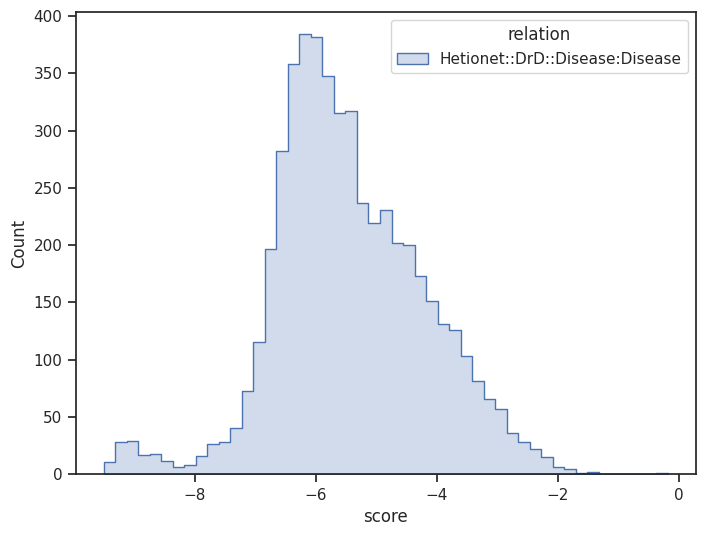

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='ticks')
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(x='score', hue='relation', data=disease_topkpd, element='step', ax=ax)

In [30]:
# Join the topkpd with the entity dataframe
disease_ave_df = entities.copy()
disease_ave_df["node_id"] = entities["label"] + "::" + entities["id"]
disease_ave_merged = disease_topkpd_ave.merge(disease_ave_df, left_on='target', right_on='node_id')
disease_ave_merged.to_csv(os.path.join(model_dir, f"similar-diseases-mecfs-ave-output.tsv"), sep="\t", index=False)
disease_ave_merged.head()

,relation,target_id,score,target,id,name,label,resource,description,synonyms,pmids,taxid,xrefs,node_id
0,Hetionet::DrD::Disease:Disease,2626,-0.260726,Disease::MESH:D001749,MESH:D001749,Urinary Bladder Neoplasms,Disease,MESH,Tumors or cancer of the URINARY BLADDER.,"Bladder Neoplasms|Neoplasm, Bladder|Urinary Bl...",NaN,NaN,HP:0009725|DOID:11054|MESH:D001749,Disease::MESH:D001749
1,Hetionet::DrD::Disease:Disease,6291,-0.389808,Disease::MESH:D012559,MESH:D012559,Schizophrenia,Disease,MESH,A severe emotional disorder of psychotic depth...,Schizophrenic Disorder|Dementia Praecox|Schizo...,NaN,NaN,MESH:D012559|HP:0100753|DOID:5419,Disease::MESH:D012559
2,Hetionet::DrD::Disease:Disease,10931,-0.395146,Disease::MESH:D004938,MESH:D004938,Esophageal Neoplasms,Disease,MESH,Tumors or cancer of the ESOPHAGUS.,"Cancer of Esophagus|Cancers, Esophagus|Esophag...",NaN,NaN,HP:0100751|DOID:5041|MESH:D004938,Disease::MESH:D004938
3,Hetionet::DrD::Disease:Disease,13550,-0.430194,Disease::MESH:D008113,MESH:D008113,Liver Neoplasms,Disease,MESH,Tumors or cancer of the LIVER.,"Hepatocellular Cancer|Cancer, Liver|Cancers, H...",NaN,NaN,MESH:D008113|HP:0002896|DOID:3571,Disease::MESH:D008113
4,Hetionet::DrD::Disease:Disease,10267,-0.447141,Disease::MESH:D013964,MESH:D013964,Thyroid Neoplasms,Disease,MESH,Tumors or cancer of the THYROID GLAND.,"Thyroid Cancer|Cancer, Thyroid|Carcinomas, Thy...",NaN,NaN,MESH:D013964|DOID:1781|DOID:2891|HP:0011774|HP...,Disease::MESH:D013964


## BioMedGPS

### Statistics of ME/CFS & LongCOVID's relations

In [ ]:
import os
root_dir = os.path.dirname(os.getcwd())
relations = pd.read_csv(os.path.join(root_dir, "graph_data", "relations.tsv"), sep="\t")
relations

In [ ]:
# Long COVID
MESH_ID = "MESH:D000094024"
MONDO_ID = "MONDO:0100233"

In [ ]:
# ME/CFS
MESH_ID = "MESH:D015673"
MONDO_ID = "MONDO:0005404"

sub_mesh_relations = relations[(relations["source_id"] == MESH_ID) | (relations["target_id"] == MESH_ID)]
sub_mondo_relations = relations[(relations["source_id"] == MONDO_ID) | (relations["target_id"] == MONDO_ID)]
print(len(sub_mesh_relations), len(sub_mondo_relations))

print(sub_mesh_relations.head())
print(sub_mondo_relations.head())

### Predict

In [ ]:
import os

dataset = 'biomedgps'
working_dir = f'./{dataset}'
idx = 0
model_dir = os.path.join(working_dir, f'models/TransE_l2_{dataset}_{idx}')
entity_idmap_file = os.path.join(working_dir, 'data/train/entities.tsv')
relation_idmap_file = os.path.join(working_dir, 'data/train/relations.tsv')
entity_emb_file = os.path.join(model_dir, f'{dataset}_TransE_l2_entity.npy')
rel_emb_file = os.path.join(model_dir, f'{dataset}_TransE_l2_relation.npy')
entity_relation_map = load_module(entity_idmap_file, relation_idmap_file, entity_emb_file, rel_emb_file)

### ME/CFS

In [ ]:
relations = ['Hetionet::CtD::Compound:Disease', 'GNBR::T::Compound:Disease', 'DRUGBANK::treats::Compound:Disease']
source_id = "MONDO:0005404"

results = query(entity_relation_map, relations, source_id)
topkpd = relation_each(entity_relation_map, results, topk=10551)
topkpd_ave = relation_ave(entity_relation_map, results, topk=10551)
topkpd, topkpd_ave

In [ ]:
expected_drugs = pd.read_csv(os.path.join(root_dir, "prediction", "deduplicated_drugs.txt"), sep='\t')
formatted_expected_drug_ids = [f'Compound::DrugBank:{drug}' for drug in expected_drugs['DrugBankID']]
expected_drugs["FormattedDrugID"] = formatted_expected_drug_ids
filtered_topkpd = topkpd[topkpd['target'].isin(formatted_expected_drug_ids)]
filtered_topkpd

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='ticks')
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(x='score', hue='relation', data=filtered_topkpd, element='step', ax=ax)

In [ ]:
# Show the score distribution with plotly
import plotly.express as px
fig = px.histogram(filtered_topkpd, x="score", nbins=100)
fig.show()

# Show me all drugs with score >= -3
print(filtered_topkpd[filtered_topkpd['score'] >= -3].shape)

filtered_topkpd["DrugName"] = [expected_drugs[expected_drugs['FormattedDrugID'] == drug_id]['DrugName'].values[0] for drug_id in filtered_topkpd['target']]
filtered_topkpd.to_csv(os.path.join(root_dir, "models/biomedgps/output.tsv"), sep="\t")

### Long COVID

In [ ]:
relations = ['Hetionet::CtD::Compound:Disease', 'GNBR::T::Compound:Disease', 'DRUGBANK::treats::Compound:Disease']
source_id = "MONDO:0100233"

results = query(entity_relation_map, relations, source_id)
topkpd = relation_each(entity_relation_map, results, topk=10551)
topkpd_ave = relation_ave(entity_relation_map, results, topk=10551)
topkpd, topkpd_ave

In [ ]:
expected_drugs = pd.read_csv(os.path.join(root_dir, "prediction", "deduplicated_drugs.txt"), sep='\t')
formatted_expected_drug_ids = [f'Compound::DrugBank:{drug}' for drug in expected_drugs['DrugBankID']]
expected_drugs["FormattedDrugID"] = formatted_expected_drug_ids
filtered_topkpd = topkpd[topkpd['target'].isin(formatted_expected_drug_ids)]
filtered_topkpd

In [ ]:
# Show the score distribution with plotly
import plotly.express as px
fig = px.histogram(filtered_topkpd, x="score", nbins=100)
fig.show()

# Show me all drugs with score >= -3
print(filtered_topkpd[filtered_topkpd['score'] >= -3].shape)

filtered_topkpd["DrugName"] = [expected_drugs[expected_drugs['FormattedDrugID'] == drug_id]['DrugName'].values[0] for drug_id in filtered_topkpd['target']]
filtered_topkpd.to_csv(os.path.join(root_dir, "models/biomedgps/long-covid-output.tsv"), sep="\t")